# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 30.01.2025

Мягкий дедлайн: 23:59MSK 16.02.2025

Жесткий дедлайн: 23:59MSK 23.02.2025

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Использование генеративных языковых моделей разрешено только в случае явного указания на это. Необходимо прописать (в соответствующих пунктах, где использовались, либо в начале/конце работы):
- какая языковая модель использовалась
- какие использовались промпты и в каких частях работы
- с какими сложностями вы столкнулись при использовании генеративных моделей, с чем они помогли больше всего

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

In [2]:
%load_ext autoreload
%autoreload 2

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import numpy as np

# 1 Способ
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()

# 2 Способ (если первый не работает)
# from sklearn.datasets import fetch_openml
# def load_fashion_mnist():
#     X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
#     X = X.reshape(-1, 28, 28).astype('uint8')
#     y = y.astype('int64')
#     x_train, x_test = X[:60000], X[60000:]
#     y_train, y_test = y[:60000], y[60000:]
#     return (x_train, y_train), (x_test, y_test)
# (x_train_pics, y_train), (x_test_pics, y_test) = load_fashion_mnist()




x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


__Задание 0. (0.25 баллов)__

**Вопрос:** зачем в алгоритме нужен метод главных компонент?

**Ответ:** Для того чтобы уменьшить размерность, а значит уменьшить сложность вычислений, также метод главных компонент поможет исключить уровень шума, что здорово.

__Задание 1. (3 балла)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса в `homework_practice_08_rff.py` (допишите его и исправьте несостыковки в классе пайплайна) или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [9]:
from homework_practice_08_rff import RFFPipeline, RandomFeatureCreator

pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator)

In [10]:
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.metrics import accuracy_score
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
print("accuracy:", accuracy_score(y_pred, y_test))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy: 0.858


__Задание 2. (2.5 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучите градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

Линейный svm:

In [ ]:

%%time
svm_classifier = LinearSVC(max_iter=10000)
svm_classifier.fit(x_train, y_train)
y_pred = svm_classifier.predict(x_test)
print('Accuracy:', accuracy_score(y_pred, y_test))

Accuracy: 0.838
CPU times: user 48min 31s, sys: 3.71 s, total: 48min 34s
Wall time: 48min 50s


Ядровой svm:

In [ ]:
%%time
svm_classifier = SVC(max_iter=10000, kernel = 'rbf')
svm_classifier.fit(x_train, y_train)
y_pred = svm_classifier.predict(x_test)
print('Accuracy:', accuracy_score(y_pred, y_test))

Accuracy: 0.8828
CPU times: user 10min 1s, sys: 3.2 s, total: 10min 4s
Wall time: 10min 11s


Линейный SVM показал более низкое качество и обучался дольше

Понизим размерность с помощью CPA и обучим CatBoost

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.3 MB/s eta 0:00:00


In [5]:
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

ModuleNotFoundError: No module named 'catboost'

In [ ]:
%%time
new_dim = PCA(50)
x_train_pca = new_dim.fit_transform(x_train)
x_test_pca = new_dim.fit_transform(x_test)

model = CatBoostClassifier()
grid = {
    'learning_rate' : [0.01, 0.09, 0.5, 1],
    'depth': [3, 4, 5, 6],
    'iterations': [50, 100, 200, 300]
}

grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=3, scoring='accuracy')

grid_search.fit(x_train_pca, y_train)

best_params = grid_search.best_params_
model_best = CatBoostClassifier(**best_params)

model_best.fit(x_train_pca, y_train)
y_pred = model_best.predict(x_test_pca)
print("Accuracy:", accuracy_score(y_test, y_pred))

Выходные данные были обрезаны до нескольких последних строк (5000).
3:	learn: 0.8030460	total: 1.43s	remaining: 1m 9s
4:	learn: 0.7455930	total: 1.77s	remaining: 1m 9s
5:	learn: 0.7073581	total: 2.12s	remaining: 1m 8s
6:	learn: 0.6672438	total: 2.48s	remaining: 1m 8s
7:	learn: 0.6390472	total: 2.83s	remaining: 1m 7s
8:	learn: 0.6200436	total: 3.17s	remaining: 1m 7s
9:	learn: 0.5991804	total: 3.53s	remaining: 1m 7s
10:	learn: 0.5760425	total: 3.87s	remaining: 1m 6s
11:	learn: 0.5623518	total: 4.22s	remaining: 1m 6s
12:	learn: 0.5429755	total: 4.58s	remaining: 1m 5s
13:	learn: 0.5291302	total: 4.93s	remaining: 1m 5s
14:	learn: 0.5168908	total: 5.28s	remaining: 1m 5s
15:	learn: 0.5026042	total: 5.65s	remaining: 1m 4s
16:	learn: 0.4953489	total: 6s	remaining: 1m 4s
17:	learn: 0.4822151	total: 6.34s	remaining: 1m 4s
18:	learn: 0.4730045	total: 6.75s	remaining: 1m 4s
19:	learn: 0.4651758	total: 7.37s	remaining: 1m 6s
20:	learn: 0.4575926	total: 8.05s	remaining: 1m 8s
21:	learn: 0.4536352	tot

C CatBoost качество заметно ниже, возможно связано с плохими гиперпараметрами, к тому же обучается оооочееень долго даже в сравнении с svm, что в целом ожидаемо

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA?
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

Посмотрим, как поведет себя модель без предварительного понижения размерности

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
model = RFFPipeline(n_features=1000, new_dim=50,use_PCA = False, feature_creator_class=RandomFeatureCreator)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("accuracy:", accuracy_score(y_pred, y_test))

accuracy: 0.108


**Результат**: Без PCA качество ужасно маленькое(

Посмотрим на связь количества признаков и качество модели

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
n_features = [1, 10, 20, 50, 75, 100, 200, 400, 600, 800, 1000]
acc_res = []
for i in n_features:
  model = model = RFFPipeline(n_features=i, new_dim=50, feature_creator_class=RandomFeatureCreator)
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  acc_res.append(accuracy_score(y_pred, y_test))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Text(0, 0.5, 'accuracy')

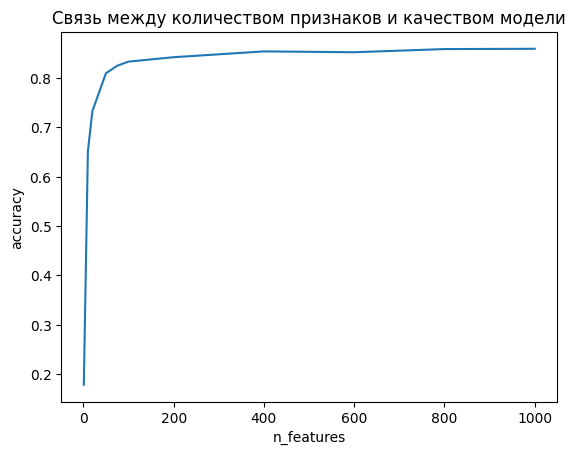

In [ ]:
plt.plot(n_features, acc_res)
plt.title('Связь между количеством признаков и качеством модели')
plt.xlabel('n_features')
plt.ylabel('accuracy')

**Результат**: видно, что качество довольно быстро выходит на плато, а значит для точности модели необязательно, чтобы изначально там было очень много признаков.

Обучим еще раз лог регрессию и SVM, посмотрим на разницу

In [ ]:
#Логистическая регрессия
model = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("accuracy:", accuracy_score(y_pred, y_test))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy: 0.8611


In [ ]:
#SVM
model = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator, classifier_class = SVC)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("accuracy:", accuracy_score(y_pred, y_test))

accuracy: 0.8645


**Результат**: Качество SVM немного выше, но обучается он заметно дольше

__Задание 4. (Максимум 1.5 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет), n_features=new_dim и n_features < new_dim также должны работать, убедитесь в этом. Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.


In [3]:
import numpy as np

from typing import Callable

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

def orthogonalize_svd(W):
    U, _, _ = np.linalg.svd(W, full_matrices=False)
    return U

class FeatureCreatorPlaceholder(BaseEstimator, TransformerMixin):
    def __init__(self, n_features, new_dim, func: Callable = np.cos):
        self.n_features = n_features
        self.new_dim = new_dim
        self.w = None
        self.b = None
        self.func = func

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X


class OrthogonalRandomFeatureCreator(FeatureCreatorPlaceholder):
    def fit(self, X, y=None):
        indexiki = np.random.randint(0, X.shape[0], size=(1000000, 2))
        D = X.shape[1]
        d = min(self.n_features, D)
        X_pairs = X[indexiki]
        sigma = np.median(np.sum(np.square(X_pairs[:, 0] - X_pairs[:, 1]), axis = 1))
        G = np.random.normal(0, 1 / np.sqrt(sigma), size = (D, d))
        Q, R = np.linalg.qr(G)
        self.w = (G @ Q) * (1 / np.sqrt(sigma))
        self.b = np.random.uniform(-np.pi, np.pi, size = self.n_features)
        return self

    def transform(self, X, y=None):
      transformation = X @ self.w + self.b
      return np.cos(transformation)


class OFFPipeline(BaseEstimator):
    """
    Пайплайн, делающий последовательно три шага:
        1. Применение PCA
        2. Применение RFF
        3. Применение классификатора
    """
    def __init__(
            self,
            n_features: int = 1000,
            new_dim: int = 50,
            use_PCA: bool = True,

            feature_creator_class=FeatureCreatorPlaceholder,
            classifier_class=LogisticRegression,
            classifier_params=None,
            func=np.cos,
    ):
        """
        :param n_features: Количество признаков, генерируемых RFF
        :param use_PCA: Использовать ли PCA
        :param feature_creator_class: Класс, создающий признаки, по умолчанию заглушка
        :param classifier_class: Класс классификатора
        :param classifier_params: Параметры, которыми инициализируется классификатор
        :param func: Функция, которую получает feature_creator при инициализации.
                     Если не хотите, можете не использовать этот параметр.
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        if classifier_params is None:
            classifier_params = {}
        self.classifier = classifier_class(**classifier_params)
        self.feature_creator = feature_creator_class(
            n_features=self.n_features, new_dim=self.new_dim, func=func
        )
        self.pipeline = None


    def fit(self, X, y):
        pipeline_steps = []
        if self.use_PCA:
          pipeline_steps.append(("pca", PCA(n_components=self.new_dim)))
        pipeline_steps.append(("rff", self.feature_creator))
        pipeline_steps.append(("classifier", self.classifier))
        self.pipeline = Pipeline(pipeline_steps).fit(X, y)
        return self

    def predict_proba(self, X):
        return self.pipeline.predict_proba(X)

    def predict(self, X):
        return self.pipeline.predict(X)


In [ ]:
model = OFFPipeline()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("accuracy:", accuracy_score(y_pred, y_test))

accuracy: 0.8254


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
model = OFFPipeline(n_features=10, new_dim = 100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("accuracy:", accuracy_score(y_pred, y_test))

accuracy: 0.8383


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Видим, что и при маленьком new_dim, и при большом, все хорошо работает

In [ ]:
model = OFFPipeline(classifier_class = SVC)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("accuracy:", accuracy_score(y_pred, y_test))

accuracy: 0.875


Качество получше, чем у RFF, обучается столько же

__Задание 5. (Максимум 1 балл)__

Существует большое количество работ, где идея RFF развивается, предлагаются её обобщения (которые, по сути, выливаются в другие преобразования признаков, не обязательно уже тригонометрические). Возьмите любую из таких работ, кратко опишите идею, имплементируйте её и сравните качество с ORF и RFF, которые вы запрограммировали выше.

Ссылки на статьи, где обсуждаются вариации RFF для разных ядер, можно найти в окрестности таблицы 1 в работе https://arxiv.org/pdf/1407.5599  

___ссылка на работу:___ https://arxiv.org/pdf/2402.16481

___описание идеи:___ Статья обсуждает методы нелинейного уменьшения размерности, такие как Laplacian Eigenmaps и Diffusion Maps, которые используют собственные значения и собственные векторы (не)нормализованных графов Лапласа. Эти методы применяются, когда данные выборки принадлежат низкоразмерному многообразию, вложенному в высокоразмерное евклидово пространство.

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import pdist, squareform

class HeatKernelFeatureCreator(BaseEstimator, TransformerMixin):
    def __init__(self, n_features, new_dim, gamma=None):
        self.n_features = n_features
        self.new_dim = new_dim
        self.gamma = gamma

    def fit(self, X, y=None):
        if self.gamma is None:
            pairwise_dists = squareform(pdist(X, 'euclidean'))
            self.gamma = 1.0 / (2 * np.median(pairwise_dists) ** 2)
        return self

    def transform(self, X, y=None):
        pairwise_dists = squareform(pdist(X, 'euclidean'))
        K = np.exp(-self.gamma * pairwise_dists ** 2)
        return K

class LaplasPipeline(BaseEstimator):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True,
                 feature_creator_class=HeatKernelFeatureCreator,
                 classifier_class=LogisticRegression, classifier_params=None):
        self.n_features = n_features
        self.new_dim = new_dim
        self.use_PCA = use_PCA
        if classifier_params is None:
            classifier_params = {}
        self.classifier = classifier_class(**classifier_params)
        self.feature_creator = feature_creator_class(n_features=self.n_features, new_dim=self.new_dim)
        self.pipeline = None

    def fit(self, X, y):
        pipeline_steps = []
        if self.use_PCA:
            pipeline_steps.append(("pca", PCA(n_components=self.new_dim)))
        pipeline_steps.append(("heat_kernel", self.feature_creator))
        pipeline_steps.append(("classifier", self.classifier))
        self.pipeline = Pipeline(pipeline_steps).fit(X, y)
        return self

    def predict_proba(self, X):
        return self.pipeline.predict_proba(X)

    def predict(self, X):
        return self.pipeline.predict(X)


Код выглядеть примерно так будет))

__Задание 6. (Максимум 2.5 балла)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск **[1 балл максимум]**, также добавьте возможность использовать аналитическую формулу **[1 балл максимум]**. Для градиентного спуска выпишите градиент ниже **[0.5 баллов максимум]**.
Подумайте о том, как в формулах правильно учесть свободный коэффициент.

Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь:
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание:
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

___Выведите градиент:___
$$
\begin{equation}
\nabla_w Q(w) = K^T (K w - y) + \lambda K w.
\end{equation}
$$

Вы можете изменять представленный шаблон в файле `homework_practice_08_kernel_regression.py` по своему усмотрению.

In [16]:
from homework_practice_08_kernel_regression import KernelRidgeRegression
from sklearn.metrics import mean_squared_error
import scipy.stats as sts

In [ ]:
from sklearn.model_selection import train_test_split
X = sts.norm.rvs(size=[10000, 20])
y = sts.norm.rvs(size=[10000, 1])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

krr = KernelRidgeRegression()
krr.fit(x_train, y_train)
y_pred = krr.predict(x_test)
print('MSE:', mean_squared_error(y_pred, y_test))

MSE: 0.9602083858667928


Обучили)))

KernelRidgeRegression работает значительно лучше чем RFF